In [1]:
# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure. More about that later. 
# If you are using an old version of IPython, try using '%pylab inline' instead.
%matplotlib inline
%load_ext snakeviz

import numpy as np
from scipy.optimize import minimize
from scipy.optimize import rosen, differential_evolution
from scipy.special import expit
import matplotlib.pyplot as plt
import scipy

from matplotlib.lines import Line2D

import timeit

import pandas as pd

import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

In [2]:
# Here are the initial values


# For test use
array12 = np.asarray(np.split(np.random.rand(1,60)[0],12))

In [3]:
# Here is the activation function

def act(x):
    return expit(x)

In [4]:
# Density matrix in the forms that I wrote down on my Neutrino Physics notebook
# x is a real array of 12 arrays.

init = np.array([1.0,0.0,0.0,0.0])

def rho(x,ti,initialCondition):
    
    elem = np.ones(4)
    
    for i in np.linspace(0,3,4):
        elem[i] = np.sum(ti*x[i*3]*act(ti*x[i*3+1] + x[i*3+2]) )
    
    return init + elem
    

In [5]:
rho(array12,0,init)

array([ 1.,  0.,  0.,  0.])

In [6]:
# Hamiltonian of the problem, in terms of four real components

hamil = np.array( [  np.cos(2.0),np.sin(2.0) , np.sin(2.0),np.cos(2.0) ] )
#hamil = 1.0/2*np.array( [  -np.cos(2.0),np.sin(2.0) , np.sin(2.0),np.cos(2.0) ] )
print hamil

[-0.41614684  0.90929743  0.90929743 -0.41614684]


In [35]:
# Cost function for each time step

def rhop(x,ti,initialCondition):
    
    rhoprime = np.zeros(4)
    

    
    for i in np.linspace(0,3,4):
        rhoprime[i] = np.sum(x[i*3] * (act(ti*x[i*3+1] + x[i*3+2]) ) ) +  np.sum( ti*x[i*3]* (act(ti*x[i*3+1] + x[i*3+2]) ) * (1 - (act(ti*x[i*3+1] + x[i*3+2])  ) )* x[i*3+1]  )
        
    
    return rhoprime


## This is the regularization

regularization = 0.0001

def costi(x,ti,initialCondition):
    
    rhoi = rho(x,ti,initialCondition)
    rhopi = rhop(x,ti,initialCondition)
    
    costTemp = np.zeros(4)
    
    costTemp[0] = ( rhopi[0] - 2.0*rhoi[2]*hamil[1] )**2
    costTemp[1] = ( rhopi[1] - 2.0*rhoi[2]*hamil[0] )**2
    costTemp[2] = ( rhopi[2] + 2.0*rhoi[1]*hamil[0] - hamil[1] * (rhoi[3] - rhoi[0] ) )**2
    costTemp[3] = ( rhopi[3] + 2.0*rhoi[2]*hamil[1] )**2
    
    return np.sum(costTemp)# + 2.0*np.sum(rhoi[0]+rhoi[3]-1.0)**2
      
#    return np.sum(costTemp) + regularization*np.sum(x**2)
    

In [36]:
costi(array12,0,init)

15.052047161648652

In [37]:
def cost(x,t,initialCondition):
    
    costTotal = map(lambda t: costi(x,t,initialCondition),t)
    
    return np.sum(costTotal)

In [38]:
cost(array12,np.array([0,1,2]),init)
#cost(xresult,np.array([0,4,11]),init)

223.5899406719337

In [39]:
# with ramdom initial guess

initGuess = np.asarray(np.split(np.random.rand(1,60)[0],12))
#initGuess = np.split(np.zeros(60),12)
endpoint = 2
tlin = np.linspace(0,endpoint,11)

costF = lambda x: cost(x,tlin,init)

startSLSQP = timeit.default_timer()
costvFResultSLSQP = minimize(costF,initGuess,method="SLSQP",tol=1e-20)
stopSLSQP = timeit.default_timer()

print stopSLSQP - startSLSQP

print costvFResultSLSQP

22.2468590736
  status: 0
 success: True
    njev: 96
    nfev: 5993
     fun: 1.0044055106205301
       x: array([-0.38533104, -1.64831368,  4.38168064,  0.23418412, -1.24310515,
        2.71208547, -1.17803337, -2.02417133,  0.58763309,  0.38533099,
       -1.64831389,  4.38168139,  0.30402688,  0.19326462,  0.82612667,
        0.76703281,  0.50934169,  0.63691252,  0.65680431,  0.89169379,
        0.89845689,  0.82312269,  0.2860762 ,  0.18070006,  0.57069152,
        0.76276688,  0.49726754,  0.08551489,  0.78223766,  0.51685773,
        0.68729879,  0.61915101,  0.23417418,  0.24190889,  0.93039299,
        0.61807191,  0.11016686,  0.71668361,  0.28829404,  0.61757678,
        0.19181149,  0.91082338,  0.71307929,  0.42801499,  0.9065759 ,
        0.37497919,  0.43890455,  0.27056948,  0.26460465,  0.86056472,
        0.12932654,  0.23620239,  0.89190562,  0.3059411 ,  0.47187494,
        0.83477634,  0.85766016,  0.37527573,  0.79620005,  0.85062391])
 message: 'Optimization ter

- **Should think about the eps(stepsize)**

In [40]:
xmid = costvFResultSLSQP.get("x")

startSLSQP = timeit.default_timer()
costvFResultSLSQP = minimize(costF,xmid,method="SLSQP",tol=1e-30,options={"ftol":1e-30,"maxiter":100000})
#costvFResultSLSQP = minimize(costF,xmid,method='Nelder-Mead',tol=1e-15,options={"ftol":1e-15, "maxfev": 1000000,"maxiter":1000000})
stopSLSQP = timeit.default_timer()

print stopSLSQP - startSLSQP

print costvFResultSLSQP

0.263801813126
  status: 0
 success: True
    njev: 1
    nfev: 73
     fun: 1.0044055106205301
       x: array([-0.38533104, -1.64831368,  4.38168064,  0.23418412, -1.24310515,
        2.71208547, -1.17803337, -2.02417133,  0.58763309,  0.38533099,
       -1.64831389,  4.38168139,  0.30402688,  0.19326462,  0.82612667,
        0.76703281,  0.50934169,  0.63691252,  0.65680431,  0.89169379,
        0.89845689,  0.82312269,  0.2860762 ,  0.18070006,  0.57069152,
        0.76276688,  0.49726754,  0.08551489,  0.78223766,  0.51685773,
        0.68729879,  0.61915101,  0.23417418,  0.24190889,  0.93039299,
        0.61807191,  0.11016686,  0.71668361,  0.28829404,  0.61757678,
        0.19181149,  0.91082338,  0.71307929,  0.42801499,  0.9065759 ,
        0.37497919,  0.43890455,  0.27056948,  0.26460465,  0.86056472,
        0.12932654,  0.23620239,  0.89190562,  0.3059411 ,  0.47187494,
        0.83477634,  0.85766016,  0.37527573,  0.79620005,  0.85062391])
 message: 'Optimization termi

In [41]:
xresult = costvFResultSLSQP.get("x")
#xresult = np.array([-0.01486401,  2.25493868, -1.84543911, -0.07335087,  2.2548026 ,
#       -1.84421662,  0.10454078, -1.64040244,  2.99923129,  0.01486399,
#        2.2549433 , -1.84544286,  0.61994826,  0.96756294,  0.60929092,
#        0.23839364,  0.45364599,  0.18426882,  0.30242425,  0.96719724,
#        0.13016584,  0.9192801 ,  0.116001  ,  0.46777053,  0.17497595,
#        0.96035958,  0.21763616,  0.73997804,  0.88071662,  0.1620245 ,
#        0.66904538,  0.66084959,  0.89772078,  0.49020208,  0.67802378,
#        0.53307714,  0.59867975,  0.16864478,  0.4257949 ,  0.5364126 ,
#        0.78476644,  0.4910997 ,  0.834945  ,  0.45061367,  0.16736545,
#        0.42579168,  0.16877594,  0.98282177,  0.08852038,  0.12633737,
#        0.50922379,  0.93146299,  0.66505978,  0.33157336,  0.05408186,
#        0.04504323,  0.27311737,  0.27651656,  0.47313653,  0.12806564])
#xresult = np.array([-1.37886409,  2.81454922, -0.3571002 ,  0.02582831, -1.05414931,
#       -1.52308153, -2.24747468,  0.33947049, -0.32310112, -1.43887103,
#        0.81176258,  0.05139705, -1.02669705, -0.97236805, -0.27536667,
#        0.34860447, -1.06962772,  0.89978175,  2.39662887, -1.45165477,
#       -1.54636469, -2.79921374, -1.30335793, -0.62844367, -3.04440811,
#       -2.74566393, -2.16222918, -1.60535643, -0.77298204,  0.13848754,
#       -0.36544212,  1.23901581, -0.80586367, -0.30212561, -1.02818302,
#       -2.82928373, -0.80776632, -2.90056107, -2.42432246, -2.87572658,
#       -0.8645904 , -0.59526987, -1.87029203, -1.60957508, -1.83106839,
#        1.07020356, -0.84892132, -0.97053555, -0.2005098 , -0.72422578,
#       -3.32948549, -4.99349947, -3.46242765, -3.52481528, -3.36820222,
#       -4.1848837 , -1.90748847, -2.09206645, -4.10831718,  2.76094325])

print xresult

[-0.38533104 -1.64831368  4.38168064  0.23418412 -1.24310515  2.71208547
 -1.17803337 -2.02417133  0.58763309  0.38533099 -1.64831389  4.38168139
  0.30402688  0.19326462  0.82612667  0.76703281  0.50934169  0.63691252
  0.65680431  0.89169379  0.89845689  0.82312269  0.2860762   0.18070006
  0.57069152  0.76276688  0.49726754  0.08551489  0.78223766  0.51685773
  0.68729879  0.61915101  0.23417418  0.24190889  0.93039299  0.61807191
  0.11016686  0.71668361  0.28829404  0.61757678  0.19181149  0.91082338
  0.71307929  0.42801499  0.9065759   0.37497919  0.43890455  0.27056948
  0.26460465  0.86056472  0.12932654  0.23620239  0.89190562  0.3059411
  0.47187494  0.83477634  0.85766016  0.37527573  0.79620005  0.85062391]


In [42]:
rho(xresult,10,init)

array([  9.99978609e-01,   1.40811472e-04,  -3.43161856e-08,
         2.13912072e-05])

In [43]:
plttlin=np.linspace(0,endpoint,100)
pltdata11 = np.array([])
for i in plttlin:
    pltdata11 = np.append(pltdata11 ,rho(xresult,i,init)[0] )
    
print pltdata11

[ 1.          0.99231489  0.98463641  0.9769649   0.9693007   0.96164417
  0.95399568  0.94635561  0.93872437  0.93110238  0.92349008  0.91588792
  0.90829638  0.90071595  0.89314714  0.8855905   0.87804657  0.87051593
  0.86299918  0.85549696  0.8480099   0.84053869  0.83308401  0.82564661
  0.81822723  0.81082665  0.8034457   0.7960852   0.78874605  0.78142913
  0.7741354   0.76686581  0.7596214   0.75240318  0.74521225  0.73804973
  0.73091676  0.72381455  0.71674434  0.70970739  0.70270504  0.69573863
  0.68880959  0.68191936  0.67506944  0.66826137  0.66149676  0.65477722
  0.64810446  0.64148022  0.63490627  0.62838445  0.62191667  0.61550485
  0.60915099  0.60285712  0.59662536  0.59045784  0.58435676  0.57832437
  0.57236298  0.56647494  0.56066266  0.55492857  0.5492752   0.54370508
  0.53822081  0.53282503  0.52752043  0.52230974  0.5171957   0.51218114
  0.50726887  0.50246178  0.49776276  0.49317473  0.48870064  0.48434345
  0.48010614  0.47599169  0.47200311  0.46814339  0

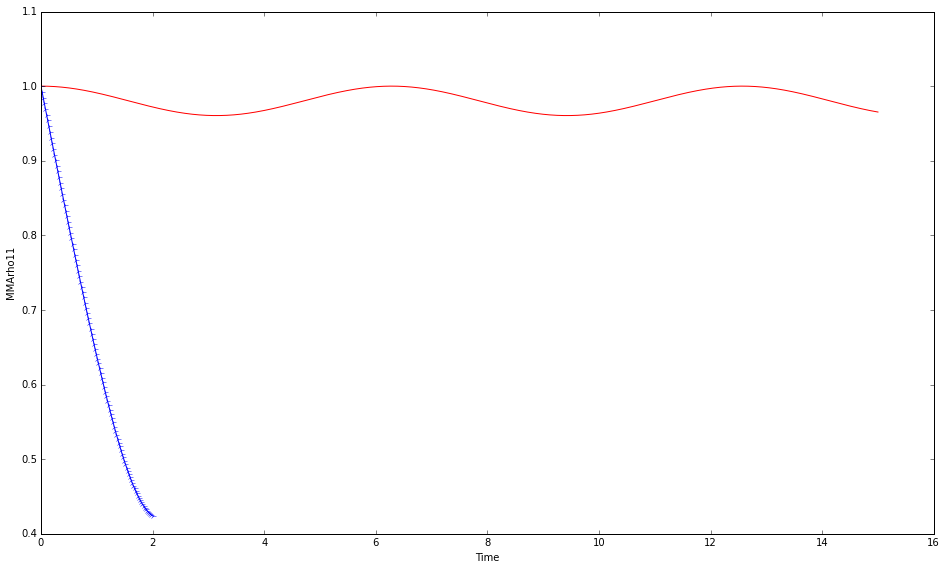

In [44]:
MMA_optmize_Vac_pltdata = np.genfromtxt('./assets/homogen/MMA_optmize_Vac_pltdata.txt', delimiter = ',')

plt.figure(figsize=(16,9.36))
plt.ylabel('MMArho11')
plt.xlabel('Time')
plt.plot(np.linspace(0,15,4501),MMA_optmize_Vac_pltdata,"r-",label="MMAVacrho11")
plt.plot(plttlin,pltdata11,"b4-",label="vac_rho11")
plt.show()
#py.iplot_mpl(plt.gcf(),filename="MMA-rho11-Vac-80-60")

In [45]:
print scipy.__version__

0.15.1


## Test Differential Evolution

In [ ]:
# with ramdom initial guess

devoendpoint = 2
devotlin = np.linspace(0,endpoint,11)

devocostF = lambda x: cost(x,devotlin,init)

bounds=np.zeros([3*4*5,2])
for i in range(3*4*5):
    bounds[i,0]=-5
    bounds[i,1]=5
#print bounds

startdevo = timeit.default_timer()
devo = differential_evolution(devocostF,bounds,strategy='best1bin',tol=1e-10,maxiter=1000,polish=True)
stopdevo = timeit.default_timer()

print stopdevo - startdevo

print devo


In [ ]:
devoxresult=devo.get("x")

In [ ]:
devoplttlin=np.linspace(0,devoendpoint,100)
devopltdata11 = np.array([])
for i in devoplttlin:
    devopltdata11 = np.append(devopltdata11 ,rho(devoxresult,i,init)[0] )
    
print devopltdata11

In [ ]:
plt.figure(figsize=(16,9.36))
plt.ylabel('MMArho11')
plt.xlabel('Time')
plt.plot(np.linspace(0,15,4501),MMA_optmize_Vac_pltdata,"r-",label="MMAVacrho11")
plt.plot(devoplttlin,devopltdata11,"b4-",label="devo_vac_rho11")
plt.show()
#py.iplot_mpl(plt.gcf(),filename="MMA-rho11-Vac-80-60")

In [ ]:
print scipy.__version__